In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import logging
import gc

import numpy as np
from scipy import interpolate
from astropy.cosmology import Planck18
import astropy.units as u

from jax import config
config.update("jax_enable_x64", True)
import jax.numpy as jnp

import py21cmfast as p21c
from py21cmfast import cache_tools

sys.path.append(os.environ['DH_DIR']) # use branch test_dm21cm
from darkhistory.spec.spectrum import Spectrum
from darkhistory.history.reionization import alphaA_recomb
from darkhistory.history.tla import compton_cooling_rate

sys.path.append("..")
import dm21cm.physics as phys
from dm21cm.dh_wrappers import DarkHistoryWrapper, TransferFunctionWrapper
from dm21cm.utils import load_h5_dict
from dm21cm.data_cacher import Cacher
from dm21cm.profiler import Profiler
from dm21cm.spectrum import AttenuatedSpectrum

logging.getLogger().setLevel(logging.INFO)
logging.getLogger('21cmFAST').setLevel(logging.CRITICAL+1)
logging.getLogger('py21cmfast._utils').setLevel(logging.CRITICAL+1)
logging.getLogger('py21cmfast.wrapper').setLevel(logging.CRITICAL+1)

/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:58: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:42: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
mpl.rc_file("../matplotlibrc")

In [3]:
import pickle

run_name = 'dhc_test'
dh_soln = pickle.load(open(f"../cross_check/run_info/{run_name}_dh_soln.p", 'rb'))
dh_xe_interp_func = lambda z: interpolate.interp1d(dh_soln['rs']-1, dh_soln['x'][:, 0])(z).item()
hep_N_arr = np.array([s.N for s in dh_soln['highengphot']])
hep_rs_arr = np.array([s.rs for s in dh_soln['highengphot']])
plot_dh_bath_N_interp_func = interpolate.interp1d(hep_rs_arr-1, hep_N_arr, axis=0)

In [4]:
sys.path.append("..")
from dm21cm.dm_params import DMParams

In [5]:
# default
debug_xray_multiplier=1.
debug_astro_params=None
save_dir=None
debug_dhc_DH_xe_func=None
debug_dhc_delta_fixed=False
debug_no_bath=False
debug_bath_point_injection=False
debug_break_after_z=None
dh_bath_N_interp_func=None
custom_YHe=None
coarsen_interp_factor=None
debug_turn_off_pop2ion=False
debug_even_split_f=False
debug_copy_dh_init=f"../cross_check/run_info/{run_name}_dh_soln.p"
track_Tk_xe=False
track_Tk_xe_set_tf_input=False
use_DH_init=True

# new
dm_params = DMParams(
    mode = 'decay',
    primary = 'elec_delta',
    m_DM = 1e8,
    lifetime = 1e25,
)

tf_version = 'zf01'


run_name = 'dhc_test'
z_start = 45.
z_end = 5.
zplusone_step_factor = 1.01
dm_params = dm_params
enable_elec = True
tf_version = tf_version

p21c_initial_conditions = p21c.initial_conditions(
    user_params = p21c.UserParams(
        HII_DIM = 16,
        BOX_LEN = 16 * 4, # [conformal Mpc]
        N_THREADS = 32,
    ),
    cosmo_params = p21c.CosmoParams(
        OMm = Planck18.Om0,
        OMb = Planck18.Ob0,
        POWER_INDEX = Planck18.meta['n'],
        #SIGMA_8 = Planck18.meta['sigma8'],
        SIGMA_8 = 1e-8,
        hlittle = Planck18.h,
    ),
    random_seed = 54321,
    write = True,
)

rerun_DH = False
clear_cache = True
use_tqdm = False
debug_flags = []
debug_xray_multiplier = 1.
debug_astro_params = p21c.AstroParams(
    L_X = 0. # log10 value
)
save_dir='run_info'
custom_YHe = 0.245
debug_dhc_delta_fixed=True
debug_dhc_DH_xe_func=dh_xe_interp_func
dh_bath_N_interp_func=dh_bath_N_interp_func
track_Tk_xe=True
track_Tk_xe_set_tf_input=False

/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/inputs.py:487: UserWarning: The USE_INTERPOLATION_TABLES setting has changed in v3.1.2 to be default True. You can likely ignore this warning, but if you relied onhaving USE_INTERPOLATION_TABLES=False by *default*, please set it explicitly. To silence this warning, set it explicitly to True. Thiswarning will be removed in v4.
  warnings.warn(


In [6]:
def get_z_edges(z_max, z_min, zplusone_step_factor):
    z_s = [z_min]
    while z_s[-1] < z_max:
        z_s.append((z_s[-1] + 1.0) * zplusone_step_factor - 1.0)
    
    return np.clip(z_s[::-1], None, z_max)


def split_xray(phot_N, phot_eng):
    """Split a photon spectrum (N in bin) into bath and xray band."""

    ex_lo, ex_hi = 1e2, 1e4 # [eV]
    ix_lo = np.searchsorted(phot_eng, ex_lo) # i of first bin greater than ex_lo, excluded
    ix_hi = np.searchsorted(phot_eng, ex_hi) # i of first bin greater than ex_hi, included

    bath_N = np.array(phot_N).copy()
    xray_N = np.array(phot_N).copy()
    bath_N[ix_lo:ix_hi] *= 0
    xray_N[:ix_lo] *= 0
    xray_N[ix_hi:] *= 0
    
    return bath_N, xray_N


def gen_injection_boxes(z_next, p21c_initial_conditions):
    
    input_heating = p21c.input_heating(redshift=z_next, init_boxes=p21c_initial_conditions, write=False)
    input_ionization = p21c.input_ionization(redshift=z_next, init_boxes=p21c_initial_conditions, write=False)
    input_jalpha = p21c.input_jalpha(redshift=z_next, init_boxes=p21c_initial_conditions, write=False)
    
    return input_heating, input_ionization, input_jalpha


def p21c_step(perturbed_field, spin_temp, ionized_box,
             input_heating=None, input_ionization=None, input_jalpha=None, astro_params=None):
    
    spin_temp = p21c.spin_temperature(
        perturbed_field = perturbed_field,
        previous_spin_temp = spin_temp,
        input_heating_box = input_heating,
        input_ionization_box = input_ionization,
        input_jalpha_box = input_jalpha,
        astro_params = astro_params,
    )
    
    ionized_box = p21c.ionize_box(
        perturbed_field = perturbed_field,
        previous_ionize_box = ionized_box,
        spin_temp = spin_temp,
        astro_params = astro_params,
    )
    
    brightness_temp = p21c.brightness_temperature(
        ionized_box = ionized_box,
        perturbed_field = perturbed_field,
        spin_temp = spin_temp,
    )
    
    return spin_temp, ionized_box, brightness_temp

In [7]:
logging.info(f'Using 21cmFAST version {p21c.__version__}')

#===== cache and memory =====
p21c.config['direc'] = f"{os.environ['P21C_CACHE_DIR']}/{run_name}"
logging.info(f"Cache dir: {p21c.config['direc']}")
os.makedirs(p21c.config['direc'], exist_ok=True)
if clear_cache:
    cache_tools.clear_cache()

gc.collect()

#===== initialize =====
#--- physics parameters ---
p21c.global_params.Z_HEAT_MAX = z_start + 1e-10
p21c.global_params.ZPRIME_STEP_FACTOR = zplusone_step_factor
p21c.global_params.CLUMPING_FACTOR = 1.
EPSILON = 1e-6
if custom_YHe is not None:
    p21c.global_params.Y_He = custom_YHe
if debug_turn_off_pop2ion:
    p21c.global_params.Pop2_ion = 0.

abscs = load_h5_dict(f"{os.environ['DM21CM_DIR']}/data/abscissas/abscs_{tf_version}.h5")
if not np.isclose(np.log(zplusone_step_factor), abscs['dlnz']):
    raise ValueError('zplusone_step_factor and tf_version mismatch')
dm_params.set_inj_specs(abscs)

box_dim = p21c_initial_conditions.user_params.HII_DIM
box_len = p21c_initial_conditions.user_params.BOX_LEN
cosmo = Planck18

#--- DarkHistory and transfer functions ---
tf_prefix = f"{os.environ['DM21CM_DATA_DIR']}/tf/{tf_version}"
tf_wrapper = TransferFunctionWrapper(
    box_dim = box_dim,
    abscs = abscs,
    prefix = tf_prefix,
    enable_elec = enable_elec,
)

#--- xray ---
xray_cacher = Cacher(data_path=f"{p21c.config['direc']}/xray_brightness.h5", cosmo=cosmo, N=box_dim, dx=box_len/box_dim)
xray_cacher.clear_cache()

#--- redshift stepping ---
z_edges = get_z_edges(z_start, z_end, p21c.global_params.ZPRIME_STEP_FACTOR)

#===== initial steps =====
dh_wrapper = DarkHistoryWrapper(
    dm_params,
    prefix = p21c.config[f'direc'],
)
if debug_copy_dh_init is not None:
    import shutil
    if os.path.exists(debug_copy_dh_init):
        shutil.copy(debug_copy_dh_init, f"{p21c.config['direc']}/dh_init_soln.p")
        logging.info(f'Copied dh_init_soln.p from {debug_copy_dh_init}')
    else:
        logging.warning(f'Could not find dh_init_soln.p at {debug_copy_dh_init}')

# We have to synchronize at the second step because 21cmFAST acts weird in the first step:
# - global_params.TK_at_Z_HEAT_MAX is not set correctly (it is probably set and evolved for a step)
# - global_params.XION_at_Z_HEAT_MAX is not set correctly (it is probably set and evolved for a step)
# - first step ignores any values added to spin_temp.Tk_box and spin_temp.x_e_box
z_match = z_edges[1]
if use_DH_init:
    dh_wrapper.evolve(end_rs=(1+z_match)*0.9, rerun=rerun_DH)
    T_k_DH_init, x_e_DH_init = dh_wrapper.get_init_cond(rs=1+z_match)
    phot_bath_spec = dh_wrapper.get_phot_bath(rs=1+z_match)
else:
    phot_bath_spec = Spectrum(abscs['photE'], np.zeros_like(abscs['photE']), spec_type='N', rs=1+z_match) # [ph / Bavg]
if debug_no_bath:
    logging.warning('Turning off bath, remember to turn back on')
    phot_bath_spec *= 0.

perturbed_field = p21c.perturb_field(redshift=z_edges[1], init_boxes=p21c_initial_conditions)
spin_temp, ionized_box, brightness_temp = p21c_step(perturbed_field=perturbed_field, spin_temp=None, ionized_box=None, astro_params=debug_astro_params)
if use_DH_init:
    spin_temp.Tk_box += T_k_DH_init - np.mean(spin_temp.Tk_box)
    spin_temp.x_e_box += x_e_DH_init - np.mean(spin_temp.x_e_box)
    ionized_box.xH_box = 1 - spin_temp.x_e_box

records = []
record = {
    'z'   : z_edges[1],
    'T_s' : np.mean(spin_temp.Ts_box), # [mK]
    'T_b' : np.mean(brightness_temp.brightness_temp), # [K]
    'T_k' : np.mean(spin_temp.Tk_box), # [K]
    'x_e' : np.mean(spin_temp.x_e_box), # [1]
    '1-x_H' : np.mean(1 - ionized_box.xH_box), # [1]
    'E_phot' : phot_bath_spec.toteng(), # [eV/Bavg]
    'phot_N' : phot_bath_spec.N, # [ph/Bavg]
    'injected_bath_N' : np.zeros_like(phot_bath_spec.N), # [ph/Bavg]
    'dE_inj_per_B' : 0.,
    'dE_inj_per_Bavg_unclustered' : 0.,
    'dep_ion'  : 0.,
    'dep_exc'  : 0.,
    'dep_heat' : 0.,
    'x_e_slice' : np.array(spin_temp.x_e_box[10]),
    'x_H_slice' : np.array(ionized_box.xH_box[10]),
}
if track_Tk_xe:
    T_k_track = np.mean(spin_temp.Tk_box)
    x_e_track = np.mean(spin_temp.x_e_box)
    record.update({
        'T_k_tracker' : T_k_track, # [K]
        'x_e_tracker' : x_e_track, # [1]
    })
records.append(record)    

INFO:root:Using 21cmFAST version 0.1.dev1585+ge3818c7.d20231008
INFO:root:Cache dir: /n/holyscratch01/iaifi_lab/yitians/21cmFAST-cache/dhc_test
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA Interpreter
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
INFO:root:TransferFunctionWrapper: Loaded photon transfer functions.
INFO:root:TransferFunctionWrapper: Loaded electron transfer functions.
INFO:root:Copied dh_init_soln.p from ../cross_check/run_info/dhc_test_dh_soln.p
INFO:root:DarkHistoryWrapper: Found existing DarkHistory initial conditions.


get_init_cond 944.9045148493365 0.01487032863184181
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 4.467847e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 4.467847e+01 E_tot_ave = 0.000000e+00


In [13]:
def plot_bath(i_z, z, spec):
    fig, ax = plt.subplots()
    ax.plot(abscs['photE'], plot_dh_bath_N_interp_func(z), color='C0', ls='-')
    ax.plot(abscs['photE'], -plot_dh_bath_N_interp_func(z), color='C0', ls='-')
    ax.plot(abscs['photE'], spec, color='C1', ls='--')
    ax.plot(abscs['photE'], -spec, color='C1', ls='-.')
    ax.text(1e7, 1e-5, f"{np.dot(abscs['photE'], plot_dh_bath_N_interp_func(z)):.4e} eV/Bavg", color='C0')
    ax.text(1e7, 1e-6, f"{np.dot(abscs['photE'], spec):.4e} eV/Bavg", color='C1')
    #ax.axvline(0.1, color='k', ls='-', alpha=0.2)
    ax.axvline(10.2, color='k', ls='-', alpha=0.2)
    ax.axvline(1e2, color='k', ls='-', alpha=0.2)
    ax.axvline(1e4, color='k', ls='-', alpha=0.2)
    ax.set(xscale='log', yscale='log', ylim=(1e-10, 1e-4))
    ax.set(title=f"i_z={i_z}, z={z:.3f}")

In [9]:
def plot_tf_slice(tf_slice):
    log10eng = np.log10(abscs['photE'])
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(np.log10(np.clip(tf_slice, 1e-40, None)), origin='lower', extent=(log10eng[0], log10eng[-1], log10eng[0], log10eng[-1]))
    axs[0].axvline(np.log10(10.2), color=cms['plasma'](0.5), ls='-', lw=1, alpha=0.5)
    axs[0].axvline(np.log10(1e2), color=cms['plasma'](0.6), ls='-', lw=1, alpha=0.5)
    axs[0].axvline(np.log10(1e4), color=cms['plasma'](0.7), ls='-', lw=1, alpha=0.5)
    axs[0].axhline(np.log10(10.2), color=cms['plasma'](0.5), ls='-', lw=1, alpha=0.5)
    axs[0].axhline(np.log10(1e2), color=cms['plasma'](0.6), ls='-', lw=1, alpha=0.5)
    axs[0].axhline(np.log10(1e4), color=cms['plasma'](0.7), ls='-', lw=1, alpha=0.5)
    axs[1].plot(log10eng, np.log10(np.diag(tf_slice)))
    axs[1].axvline(np.log10(10.2), color=cms['plasma'](0.5), ls='-', lw=1, alpha=0.5)
    axs[1].axvline(np.log10(1e2), color=cms['plasma'](0.6), ls='-', lw=1, alpha=0.5)
    axs[1].axvline(np.log10(1e4), color=cms['plasma'](0.7), ls='-', lw=1, alpha=0.5)
    axs[1].set(ylim=(-20, 1))

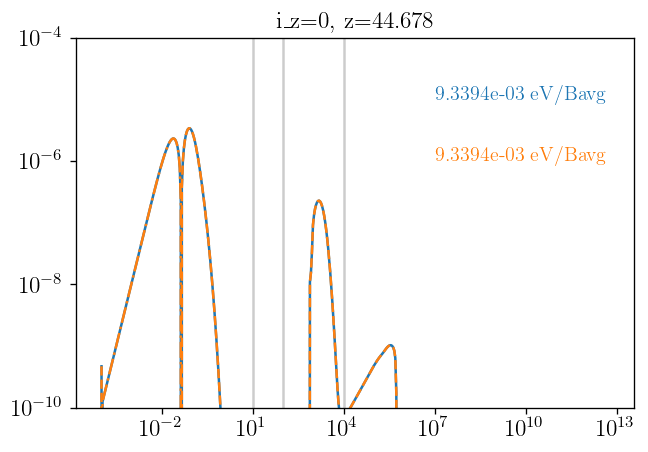

In [14]:
plot_bath(0, z_edges[1], phot_bath_spec.N)

In [15]:
#===== main loop =====
#--- trackers ---
if 'xraycheck' in debug_flags:
    i_xraycheck_loop_start = 0
else:
    i_xray_loop_start = 0 # where we start looking for annuli

profiler = Profiler()

z_edges = z_edges[1:] # Maybe fix this later
z_iterator = range(len(z_edges)-1)
if use_tqdm:
    from tqdm import tqdm
    z_iterator = tqdm(z_iterator)
print_str = ''

In [16]:
z_iterator = iter(z_iterator)

In [61]:
#--- loop ---
i_z = next(z_iterator)
print(i_z)

2


In [62]:
track_Tk_xe_set_tf_input=False

In [63]:
print(f'i_z={i_z}/{len(z_edges)-2} z={z_edges[i_z]:.2f}', file=sys.stderr, flush=True)
print_str += f'i_z={i_z}/{len(z_edges)-2} z={z_edges[i_z]:.2f}'

z_current = z_edges[i_z]
z_next = z_edges[i_z+1]
# dt = ( cosmo.age(z_next) - cosmo.age(z_current) ).to('s').value # cosmo
# dt = np.interp(1+z_current, abscs['rs'], dts[:,1])
dt = phys.dt_step(z_current, np.exp(abscs['dlnz']))

nBavg = phys.n_B * (1+z_current)**3 # [Bavg / (physical cm)^3]
delta_plus_one_box = 1 + np.asarray(perturbed_field.density)
rho_DM_box = delta_plus_one_box * phys.rho_DM * (1+z_current)**3 # [eV/(physical cm)^3]
if 'xraycheck' in debug_flags:
    x_e_box = np.asarray(spin_temp.x_e_box)
else:
    # logging.warning('\nusing xe = 1 - mean(ionized_box.xH_box) for deposition\n')
    x_e_box = np.asarray(1 - ionized_box.xH_box)
inj_per_Bavg_box = phys.inj_rate(rho_DM_box, dm_params) * dt * dm_params.struct_boost(1+z_current) / nBavg # [inj/Bavg]

if debug_dhc_DH_xe_func is not None:
    x_e_box_tf = jnp.full_like(x_e_box, debug_dhc_DH_xe_func(z_current))
else:
    x_e_box_tf = x_e_box
if debug_dhc_delta_fixed:
    delta_plus_one_box_tf = jnp.full_like(delta_plus_one_box, 1.)
else:
    delta_plus_one_box_tf = delta_plus_one_box
if track_Tk_xe_set_tf_input:
    x_e_box_tf = jnp.full_like(x_e_box, x_e_track)
    logging.warning(f'Setting x_e_box_tf to x_e_track.')
    #delta_plus_one_box_tf = jnp.full_like(delta_plus_one_box, 1.)
tf_wrapper.init_step(
    rs = 1 + z_current,
    delta_plus_one_box = delta_plus_one_box_tf,
    x_e_box = x_e_box_tf,
)

i_z=2/203 z=43.78


In [64]:
i_xray_loop_start, i_z

(0, 2)

In [65]:
#===== photon injection and energy deposition =====
#--- xray ---
for i_z_shell in range(i_xray_loop_start, i_z):

    xray_brightness_box, xray_spec, is_box_average = xray_cacher.get_annulus_data(
        z_current, z_edges[i_z_shell], z_edges[i_z_shell+1]
    )
    # If we are smoothing on the scale of the box then dump to the global bath spectrum.
    # The deposition will happen with `phot_bath_spec`, and we will not revisit this shell.
    if is_box_average or 'uniform_xray' in debug_flags:
        #phot_bath_spec.N += xray_brightness_box[0, 0, 0] * xray_spec.N # TMP: fix the [0,0,0]
        phot_bath_spec.N += xray_spec.N
        i_xray_loop_start = max(i_z_shell+1, i_xray_loop_start)
    else:
        print(f'DEBUG uniform-xray: xray_brightness_box = {np.mean(xray_brightness_box):.3e}')
        tf_wrapper.inject_phot(xray_spec, inject_type='xray', weight_box=xray_brightness_box)

DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00


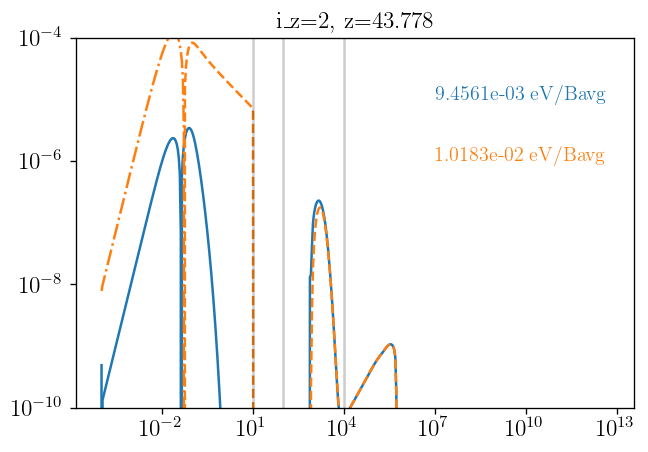

In [66]:
plot_bath(i_z, z_current, phot_bath_spec.N)

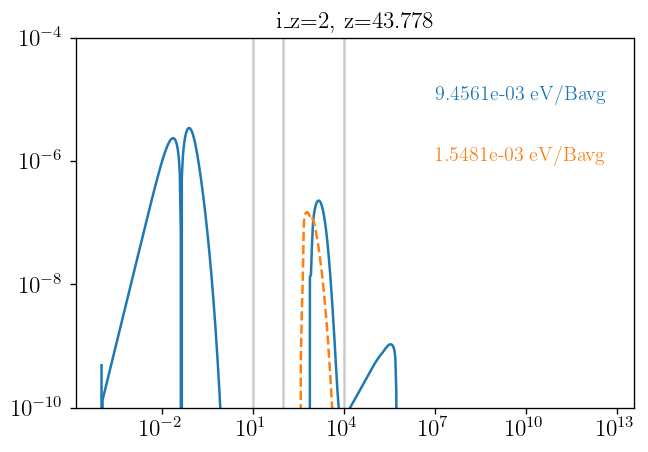

In [67]:
plot_bath(i_z, z_current, xray_spec.N)

In [68]:
#--- bath and homogeneous portion of xray ---
injected_bath_N = np.array(phot_bath_spec.N)
tf_wrapper.inject_phot(phot_bath_spec, inject_type='bath')

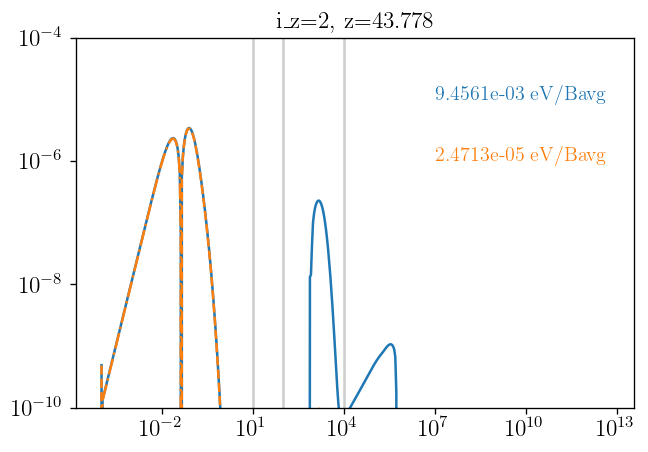

In [69]:
plot_bath(i_z, z_current, tf_wrapper.emit_phot_N)

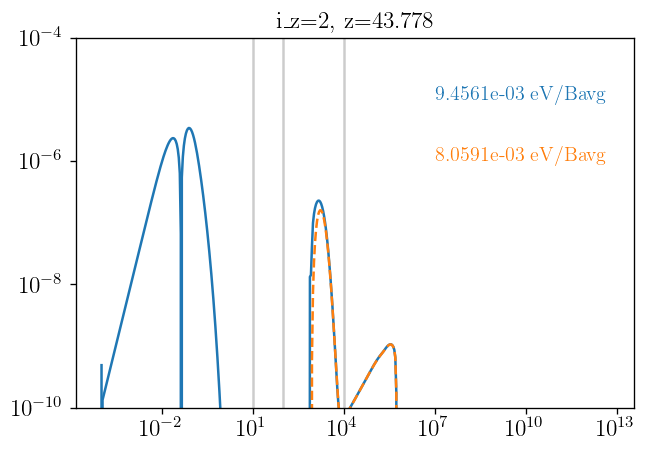

In [70]:
plot_bath(i_z, z_current, tf_wrapper.prop_phot_N)

In [ ]:
plot_tf_slice(tf_wrapper.elec_scat_tf.data[-1, :, 6, 2, :])

In [ ]:
plot_tf_slice(tf_wrapper.phot_scat_tf.data[-1, :, 6, 2, :])

In [71]:
tmp_emit_phot_N = np.array(tf_wrapper.emit_phot_N)
tf_wrapper.emit_phot_N *= 0.

In [72]:
#--- dark matter (on-the-spot) ---
tf_wrapper.inject_from_dm(dm_params, inj_per_Bavg_box)

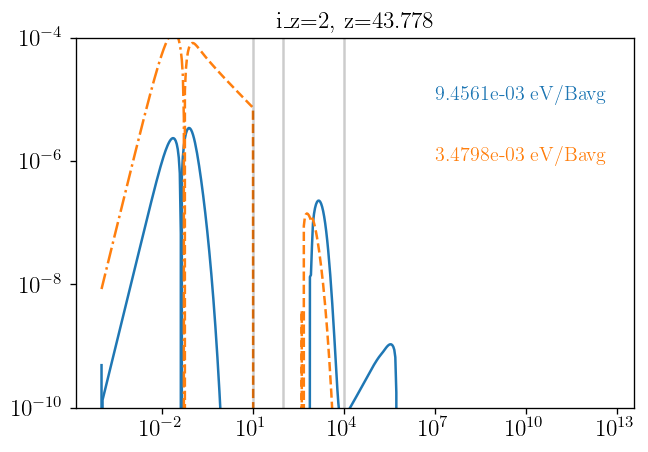

In [73]:
plot_bath(i_z, z_current, tf_wrapper.emit_phot_N)

In [74]:
tf_wrapper.emit_phot_N += tmp_emit_phot_N

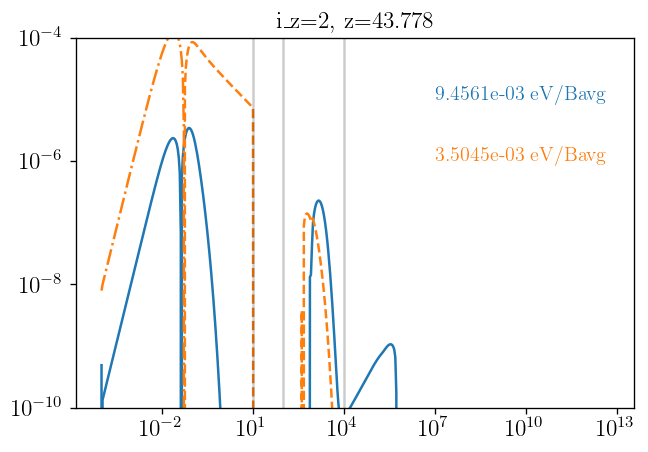

In [75]:
plot_bath(i_z, z_current, tf_wrapper.emit_phot_N)

In [76]:
#===== 21cmFAST step =====
if i_z > 0: # TEMPORARY: catch NaNs before they go into 21cmFAST
    if np.any(np.isnan(input_heating.input_heating)):
        raise ValueError('input_heating.input_heating has NaNs')
    if np.any(np.isnan(input_ionization.input_ionization)):
        raise ValueError('input_ionization.input_ionization has NaNs')
    if np.any(np.isnan(input_jalpha.input_jalpha)):
        raise ValueError('input_jalpha.input_jalpha has NaNs')
perturbed_field = p21c.perturb_field(redshift=z_next, init_boxes=p21c_initial_conditions)
input_heating, input_ionization, input_jalpha = gen_injection_boxes(z_next, p21c_initial_conditions)
tf_wrapper.populate_injection_boxes(input_heating, input_ionization, input_jalpha, dt, debug_even_split_f=debug_even_split_f)
print('before', np.mean(spin_temp.Tk_box), np.mean(spin_temp.x_e_box), flush=True)
print('input_heating', np.mean(input_heating.input_heating), flush=True)
spin_temp, ionized_box, brightness_temp = p21c_step(
    perturbed_field, spin_temp, ionized_box,
    input_heating = input_heating,
    input_ionization = input_ionization,
    input_jalpha = input_jalpha,
    astro_params=debug_astro_params
)
print('after', np.mean(spin_temp.Tk_box), np.mean(spin_temp.x_e_box), flush=True)

before 929.28516 0.0150803365
input_heating 47.526104
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 4.333507e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 4.333507e+01 E_tot_ave = 0.000000e+00
after 925.91693 0.015204384


In [77]:
T_k_track += np.mean(input_heating.input_heating)
x_e_track += np.mean(input_ionization.input_ionization)

T = T_k_track
x = x_e_track
z = z_current
rs = 1 + z

dxion_sink_dt = - alphaA_recomb('HII', phys.kB*T) * x**2 * phys.n_H * (1+z)**3
x_e_track += dxion_sink_dt * dt

dTdz_adia = 2 * T / (1 + z)
#dcomp_dzp = dcomp_dzp_prefactor * (x_e_track/(1 + x_e_track)) * ( Trad_fast - T ); # 21cmFAST
dTdz_comp_DH = compton_cooling_rate(x, phys.chi*x, 0, phys.kB*T, rs) * phys.dtdz(rs) / phys.kB / (3/2 * phys.n_H * (rs**3) * (1 + phys.chi + x))
T_k_track += (dTdz_adia + dTdz_comp_DH) * (z_next - z)

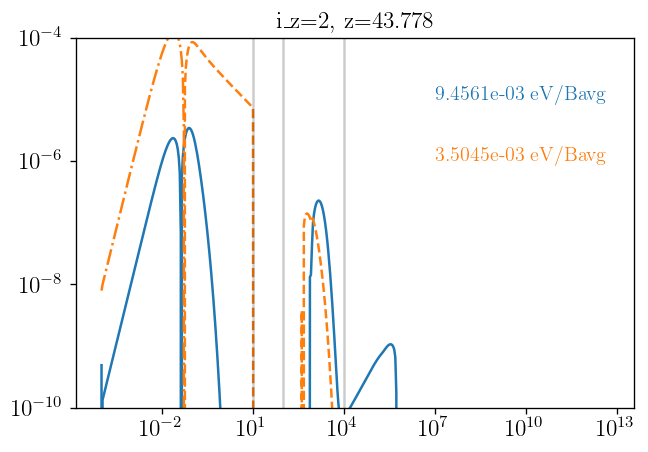

In [78]:
plot_bath(i_z, z_current, tf_wrapper.emit_phot_N)

In [79]:
#===== prepare spectra for next step =====
#--- bath (separating out xray) ---
prop_phot_N, emit_phot_N = tf_wrapper.prop_phot_N, tf_wrapper.emit_phot_N
# propagating and emitted photons have been stored in tf_wrapper up to this point, time to get them out

In [80]:
emit_bath_N, emit_xray_N = split_xray(emit_phot_N, abscs['photE'])

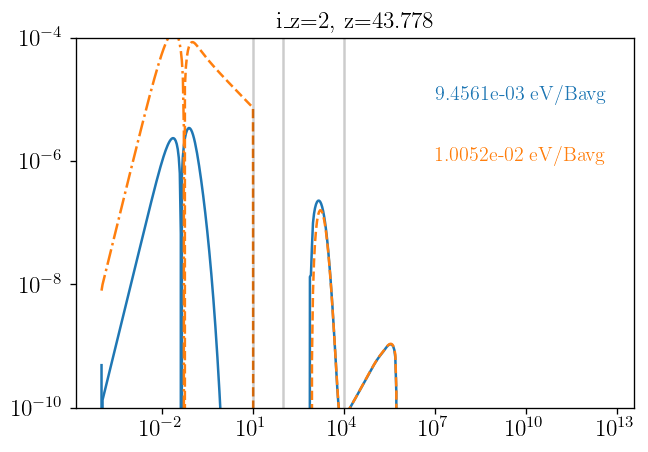

In [82]:
plot_bath(i_z, z_current, prop_phot_N+emit_bath_N)

In [83]:
prop_phot_N = np.array(prop_phot_N)
prop_phot_N[149] = 0.
phot_bath_spec = Spectrum(abscs['photE'], prop_phot_N + emit_bath_N, rs=1+z_current, spec_type='N') # photons not emitted to the xray band are added to the bath (treated as uniform)
phot_bath_spec.redshift(1+z_next)
if debug_no_bath:
    phot_bath_spec *= 0.

#--- xray ---
x_e_for_attenuation = 1 - np.mean(ionized_box.xH_box)
attenuation_arr = np.array(tf_wrapper.attenuation_arr(rs=1+z_current, x=np.mean(x_e_for_attenuation))) # convert from jax array
xray_cacher.advance_spectrum(attenuation_arr, z_next)

xray_spec = Spectrum(abscs['photE'], emit_xray_N, rs=1+z_current, spec_type='N') # [ph / Bavg]
xray_spec.redshift(1+z_next)
xray_tot_eng = np.dot(abscs['photE'], emit_xray_N)
print(f'DM21CM DEBUG: xray_tot_eng={xray_tot_eng:.3e} eV/Bavg')
if xray_tot_eng == 0.:
    xray_rel_eng_box = np.zeros_like(tf_wrapper.xray_eng_box)
else:
    xray_rel_eng_box = tf_wrapper.xray_eng_box / xray_tot_eng # [1 (relative energy) / Bavg]
print(f'DM21CM DEBUG: xray_rel_eng_box={np.mean(xray_rel_eng_box):.3e} 1/Bavg')
xray_cacher.cache(z_current, xray_rel_eng_box, xray_spec)

#===== calculate and save some global quantities =====
dE_inj_per_Bavg = dm_params.eng_per_inj * np.mean(inj_per_Bavg_box) # [eV per Bavg]
dE_inj_per_Bavg_unclustered = dE_inj_per_Bavg / dm_params.struct_boost(1+z_current)

record = {
    'z'   : z_next,
    'T_s' : np.mean(spin_temp.Ts_box), # [mK]
    'T_b' : np.mean(brightness_temp.brightness_temp), # [K]
    'T_k' : np.mean(spin_temp.Tk_box), # [K]
    'x_e' : np.mean(spin_temp.x_e_box), # [1]
    '1-x_H' : np.mean(1 - ionized_box.xH_box), # [1]
    'E_phot' : phot_bath_spec.toteng(), # [eV/Bavg]
    'phot_N' : phot_bath_spec.N, # [ph/Bavg]
    'injected_bath_N' : injected_bath_N, # [ph/Bavg]
    'dE_inj_per_B' : dE_inj_per_Bavg,
    'dE_inj_per_Bavg_unclustered' : dE_inj_per_Bavg_unclustered,
    'dep_ion'  : np.mean(tf_wrapper.dep_box[...,0] + tf_wrapper.dep_box[...,1]),
    'dep_exc'  : np.mean(tf_wrapper.dep_box[...,2]),
    'dep_heat' : np.mean(tf_wrapper.dep_box[...,3]),
    'x_e_slice' : np.array(spin_temp.x_e_box[10]),
    'x_H_slice' : np.array(ionized_box.xH_box[10]),
}
if track_Tk_xe:
    record.update({
        'T_k_tracker' : T_k_track, # [K]
        'x_e_tracker' : x_e_track, # [1]
    })
records.append(record)

#===== compare f =====
f_point = tf_wrapper.phot_dep_tf.point_interp(rs=1+z_current, nBs=1., x=np.mean(spin_temp.x_e_box))
inj_N = dm_params.inj_phot_spec.N / dm_params.inj_phot_spec.toteng()

DM21CM DEBUG: xray_tot_eng=1.512e-03 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg


/tmp/ipykernel_208025/866316955.py:55: RuntimeWarning: invalid value encountered in divide
  inj_N = dm_params.inj_phot_spec.N / dm_params.inj_phot_spec.toteng()


In [85]:
records[2]

{'z': 43.77841886391038,
 'T_s': 340.85626,
 'T_b': 36.200558,
 'T_k': 929.28516,
 'x_e': 0.0150803365,
 '1-x_H': 0.015080333,
 'E_phot': 0.01018326396635343,
 'phot_N': array([-7.84574109e-09, -9.75618073e-09, -1.13883209e-08, -1.32929670e-08,
        -1.55153575e-08, -1.81086166e-08, -2.11345928e-08, -2.46651235e-08,
        -2.87842657e-08, -3.35902575e-08, -3.91971746e-08, -4.57378626e-08,
        -5.33682338e-08, -6.22691887e-08, -7.26509515e-08, -8.47601706e-08,
        -9.88834881e-08, -1.15353497e-07, -1.34559435e-07, -1.56954699e-07,
        -1.83065219e-07, -2.13503254e-07, -2.48984598e-07, -2.90338358e-07,
        -3.38526253e-07, -3.94673216e-07, -4.60081667e-07, -5.36258183e-07,
        -6.24960517e-07, -7.28224238e-07, -8.48399955e-07, -9.88213177e-07,
        -1.15082421e-06, -1.33987104e-06, -1.55954489e-06, -1.81470113e-06,
        -2.11090565e-06, -2.45453444e-06, -2.85293119e-06, -3.31447777e-06,
        -3.84871076e-06, -4.46650580e-06, -5.18020013e-06, -6.00369358e